In [2]:
%load_ext autoreload
%autoreload 2

In [36]:
import sys, os, inspect
# Load python source folder
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
srcdir = os.path.join(parentdir, "macega")
if srcdir not in sys.path: sys.path.insert(0, srcdir)
from macega_phasevol import MacegaPhaseEvolve

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from amuse.units import units, constants
sns.set(font_scale=1.5, rc={'text.usetex' : True})
sns.set_style("ticks")
pd.set_option("max_columns", None)

In [5]:
ce_bse = pd.read_csv("../../DynBinEv/data/listOfCommonEnvelope.dat", delim_whitespace=True, header=0)
ce_bse

,ID,tce,k1_i,k2_i,m1_i,m2_i,r1_i,r2_i,mc1_i,mc2_i,rc1_i,rc2_i,sma_i,ecc_i,k1_f,k2_f,m1_f,m2_f,r1_f,r2_f,sma_f,remark
0,3,19.6331,4,1,12.511,11.483,267.0,7.90,4.194,0.000,9.2600,0.00000,1180.0,0.780000,7,1,4.194,11.483,9.2600,7.90000,53.50,Others
1,13,26.5635,5,4,10.295,10.310,722.0,346.00,3.546,3.492,7.1900,3.41000,1910.0,0.000128,8,7,3.546,3.492,7.1900,3.41000,18.90,Others
2,15,24.2294,3,1,10.468,9.985,404.0,6.74,2.336,0.000,13.9000,0.00000,856.0,0.092100,7,1,2.336,9.985,13.9000,6.74000,42.90,Others
3,18,13.4620,5,1,15.696,14.914,1270.0,8.42,6.175,0.000,114.0000,0.00000,2500.0,0.195000,8,1,6.175,14.914,114.0000,8.42000,280.00,Others
4,25,16.3303,4,4,14.137,13.638,806.0,33.00,5.021,3.408,0.0991,0.00346,17600.0,0.954000,7,7,5.021,3.408,0.0991,0.00346,2.00,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2654,9992,14.1316,5,1,15.330,10.143,1200.0,3.98,5.909,0.000,68.0000,0.00000,2900.0,0.434000,8,1,5.909,10.143,68.0000,3.98000,204.00,Others
2655,9995,18.1706,4,1,13.138,11.584,127.0,6.50,4.237,0.000,1.1300,0.00000,2210.0,0.941000,7,1,4.237,11.584,1.1300,6.50000,25.70,Others
2656,9996,5.5784,14,4,28.698,86.865,0.0,6460.00,0.000,40.557,0.0000,2440.00000,119.0,0.000000,14,7,28.698,40.557,0.0000,2440.00000,52.30,Others
2657,9999,9.1249,14,4,8.281,43.181,0.0,520.00,0.000,15.840,0.0000,20.80000,522.0,0.335000,14,7,8.281,15.840,0.0000,20.80000,25.10,Others


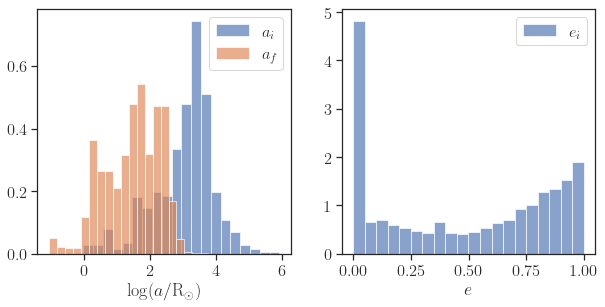

In [6]:
f, ax = plt.subplots(1,2, figsize=(10, 4.5))
ax[0].hist(np.log10(ce_bse["sma_i"]), label="$a_i$", density=True, alpha=0.66, bins=20)
ax[0].hist(np.log10(ce_bse["sma_f"]), label="$a_f$", density=True, alpha=0.66, bins=20)
ax[0].set_xlabel("$\log(a / \mathrm{R}_\odot)$")
ax[0].legend()
ax[1].hist(ce_bse["ecc_i"], label="$e_i$", density=True, alpha=0.66, bins=20)
ax[1].legend()
ax[1].set_xlabel("$e$")
plt.show()

In [64]:
def simulate_CE(a0, e0, a1, m1, m2, nu0=np.pi, ome0=0.0, X=0.05, l=2, k=1):
    mu = (m1 + m2)*constants.G
    CEvolve = MacegaPhaseEvolve(l=l, k=k, evolve_g=False, mute=True)
    C, Lex, Tex = MacegaPhaseEvolve.C_from_X(X, mu, a0, l=l, k=k)
    CEvolve.initialize_system(m1, m2, a0, e0, ome0, nu0, C=C, a1=a1)
    t, a, e, ome, nu, g = CEvolve.run_system(tfin=CEvolve.Period0*1e6, dt_out=CEvolve.Period0*0.01)
    return a[-1], e[-1], t[-1]

### Single sim test

In [75]:
inum=6
a0 = ce_bse["sma_i"][inum] | units.RSun
e0 = ce_bse["ecc_i"][inum]
a1 = ce_bse["sma_f"][inum] | units.RSun
m1 = ce_bse["m1_i"][inum] | units.MSun
m2 = ce_bse["m2_i"][inum] | units.MSun
print(a0, e0, a1)
af, ef, tf = simulate_CE(a0, e0, a1, m1, m2, nu0=np.pi, ome0=0.0, X=0.05, l=2, k=1)
print(af, ef, tf)

38.7 RSun 0.0 5.87 RSun
5.87 0.0 0.06772898749473341


In [ ]:
for i, row in enumerate(ce_bse[0:].itertuples()):
    a0 = row.sma_i | units.RSun
    e0 = row.ecc_i
    a1 = row.sma_f | units.RSun
    m1 = row.m1_i | units.MSun
    m2 = row.m2_i | units.MSun
    af, ef, tf = simulate_CE(a0, e0, a1, m1, m2, X=0.05, l=2, k=1)
    print(i, e0, ef, a0, a1, tf)
    
    

0 0.78 1180.0 RSun 53.5 RSun
1 0.000128 1910.0 RSun 18.9 RSun
2 0.0921 856.0 RSun 42.9 RSun
3 0.195 2500.0 RSun 280.0 RSun
4 0.954 17600.0 RSun 2.0 RSun


/home/lex/Work/bse/nbody/DynBinEv/macega/macega_phasevol.py:184: RuntimeWarning: invalid value encountered in double_scalars
  adot *= self.ome2**-((l+1+2*k)/2) * (1 + e*self.cosnu)**k * self.elfac**((l+1)/2)
/home/lex/Work/bse/nbody/DynBinEv/macega/macega_phasevol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  nudot = n * opecosnu * opecosnu / self.ome2 ** 1.5
/home/lex/Work/bse/nbody/DynBinEv/macega/macega_phasevol.py:189: RuntimeWarning: invalid value encountered in double_scalars
  edot *= self.ome2**-((l-1+2*k)/2) * (1 + e*self.cosnu)**k * self.elfac**((l-1)/2) * (e + self.cosnu)
/home/lex/Work/bse/nbody/DynBinEv/macega/macega_phasevol.py:194: RuntimeWarning: invalid value encountered in double_scalars
  omedot *= self.ome2**-((l-1+2*k)/2) * (1 + e*self.cosnu)**k * self.elfac**((l-1)/2) * self.sinnu / e


5 0.871 1550.0 RSun 38.6 RSun
6 0.0 38.7 RSun 5.87 RSun
7 0.0 5.86 RSun 1.03 RSun
8 0.87 9970.0 RSun 11.4 RSun
9 0.00112 1810.0 RSun 2.08 RSun
10 0.903 997.0 RSun 36.4 RSun
11 0.0 36.5 RSun 5.58 RSun
12 0.0274 4000.0 RSun 56.5 RSun
13 0.218 2510.0 RSun 200.0 RSun
14 0.868 2650.0 RSun 47.0 RSun
15 0.936 4420.0 RSun 5.7 RSun
16 0.107 5210.0 RSun 496.0 RSun
17 0.123 2460.0 RSun 182.0 RSun
18 0.0 213.0 RSun 2.05 RSun
19 0.255 215.0 RSun 7.7 RSun
20 0.919 1110.0 RSun 54.1 RSun
21 0.634 5840.0 RSun 436.0 RSun
22 0.0 250.0 RSun 2.1 RSun
23 0.508 2470.0 RSun 75.4 RSun
24 0.0364 4630.0 RSun 391.0 RSun
25 0.0207 3420.0 RSun 11.0 RSun
26 0.887 3800.0 RSun 77.5 RSun
27 0.0529 1820.0 RSun 2.3 RSun
28 0.0564 3180.0 RSun 237.0 RSun
29 0.0343 3330.0 RSun 252.0 RSun
30 0.958 3220.0 RSun 27.5 RSun
31 0.23 36.0 RSun 1.77 RSun
32 0.917 2730.0 RSun 28.4 RSun
33 0.0 44.6 RSun 1.74 RSun
34 0.732 1480.0 RSun 2.98 RSun
35 0.869 10200.0 RSun 316.0 RSun
36 0.576 215.0 RSun 22.5 RSun
37 0.486 892.0 RSun 84.2 RSun